### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from ddpg_agent_p2 import Agent # load Agent from ddpg_agent_p2.py

In [3]:
env = UnityEnvironment(file_name='E:/code/deep-reinforcement-learning/p2_continuous-control/Reacher_Windows_x86_64_v2/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
def ddpg(n_episodes=1000, max_t=1000, print_every=10, average_every=100):
    """The interface that calls ddpg agent and env
    Params
    ======
      n_episode (int): total number episode to run
      max_t (int): max number of time steps in one episode
      print_every: print the average score of agents and episodes every episode interval
      average_every: take the average score of agents and episodes over the lat average_every episodes
    """
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    a_size = brain.vector_action_space_size
    s_size = env_info.vector_observations.shape[1]
    
    agent = Agent(state_size=s_size, action_size=a_size, random_seed=2) # create agent
    
    scores_history = [] # store the average scores of arms over episodes
    scores_deque = deque(maxlen = average_every) # store the recent average scores
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations # get initial states of arms
        agent.reset()
        scores = np.zeros(num_agents)
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # save the tuples of arms in the agent's buffer
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
                        
            scores += rewards
            states = next_states
            if np.any(dones):
                break
        
        run_time = time.time() - start_time
        scores_deque.append(np.mean(scores))
        scores_history.append(np.mean(scores))
        print('\rEpisode {}\tScore: {:.2f}\tRuntime: {:.2f} sec'.format(i_episode, np.mean(scores), run_time))
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 30:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        
    return scores_history

agent constructor is called
Episode 1	Score: 0.61	Runtime: 164.97 sec
Episode 2	Score: 1.89	Runtime: 164.50 sec
Episode 3	Score: 2.93	Runtime: 166.90 sec
Episode 4	Score: 3.25	Runtime: 161.09 sec
Episode 5	Score: 3.87	Runtime: 162.83 sec
Episode 6	Score: 3.32	Runtime: 161.56 sec
Episode 7	Score: 3.67	Runtime: 173.33 sec
Episode 8	Score: 4.43	Runtime: 179.41 sec
Episode 9	Score: 5.12	Runtime: 187.27 sec
Episode 10	Score: 5.68	Runtime: 190.94 sec
Episode 10	Average Score: 3.48
Episode 11	Score: 5.74	Runtime: 193.24 sec
Episode 12	Score: 5.77	Runtime: 203.13 sec
Episode 13	Score: 5.79	Runtime: 191.52 sec
Episode 14	Score: 7.71	Runtime: 188.74 sec
Episode 15	Score: 8.63	Runtime: 196.92 sec
Episode 16	Score: 7.56	Runtime: 204.06 sec
Episode 17	Score: 9.03	Runtime: 202.73 sec
Episode 18	Score: 9.25	Runtime: 203.05 sec
Episode 19	Score: 9.48	Runtime: 204.11 sec
Episode 20	Score: 10.02	Runtime: 200.54 sec
Episode 20	Average Score: 5.69
Episode 21	Score: 10.60	Runtime: 202.33 sec
Episode 22	Sco

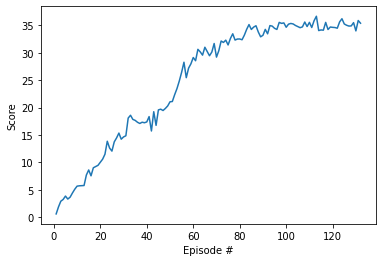

In [6]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# watch the performance of the trained agent
env_info = env.reset(train_mode=False)[brain_name]

num_agents = len(env_info.agents)
a_size = brain.vector_action_space_size
s_size = env_info.vector_observations.shape[1]

agent = Agent(state_size=s_size, action_size=a_size, random_seed=2)

# load the saved weights into the agent
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

states = env_info.vector_observations   # get initial states
scores = np.zeros(num_agents)

while True:
    actions = agent.act(states)                 # get actions over arms
    env_info = env.step(actions)[brain_name]    # take actions for arms
    next_states = env_info.vector_observations  # get new states of arms
    rewards = env_info.rewards                  # get rewards
    dones = env_info.local_done                 # get done signals
    scores += env_info.rewards                  # accumulate scores
    states = next_states                        # update states
    if np.any(dones):
        break
print('Total score: {}'.format(np.mean(scores)))

Total score: 2.9269999345764517


In [11]:
env.close()